In [1]:
# this part for colab. if you work local then skip this part
from google.colab import drive
drive.mount('/content/drive/')



import os
import numpy as np
from tqdm import tqdm
import cv2
import matplotlib.pyplot as plt
%matplotlib inline

os.chdir("/content/drive/MyDrive/yapay_zeka_video/S-004-Brain-Tumor-Detection/")

from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow.keras.layers import *

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [2]:
# Dataset from https://www.kaggle.com/navoneel/brain-mri-images-for-brain-tumor-detection
data=[]
# yes=1,no=0
label=[]

files=os.listdir("brain_tumor_dataset/no/")
print("No :")
for file_data in tqdm(files):
  data.append(cv2.imread("brain_tumor_dataset/no/"+file_data,cv2.COLOR_BGR2GRAY))
  label.append([0])

files=os.listdir("brain_tumor_dataset/yes/")
print("Yes :")
for file_data in tqdm(files):
  data.append(cv2.imread("brain_tumor_dataset/yes/"+file_data,cv2.COLOR_BGR2GRAY))
  label.append([1])


No :


100%|██████████| 98/98 [00:00<00:00, 183.49it/s]


Yes :


100%|██████████| 155/155 [00:00<00:00, 156.04it/s]


In [3]:
# preprossesing data
temp_data,temp_label=[],[]
img_size=224
# resize and normalize
for x in range(len(data)):
  data[x]=cv2.resize(data[x], (img_size,img_size), interpolation = cv2.INTER_AREA)
  data[x]=cv2.normalize(data[x], None, alpha=0, beta=1, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_32F)
  temp2=np.array(data[x])
  if temp2.shape==(img_size,img_size,3):
    temp_data.append(temp2)
    temp_label.append(label[x])


label=np.array(temp_label)
data=np.array(temp_data)
del temp_data,temp_label

# split data
x_train, x_test, y_train, y_test = train_test_split(data, label, test_size=0.2, random_state=42)
del data,label

print("x_train :",x_train.shape)
print("y_train :",y_train.shape)
print("x_test  :",x_test.shape)
print("y_test :",y_test.shape)

x_train : (178, 224, 224, 3)
y_train : (178, 1)
x_test  : (45, 224, 224, 3)
y_test : (45, 1)


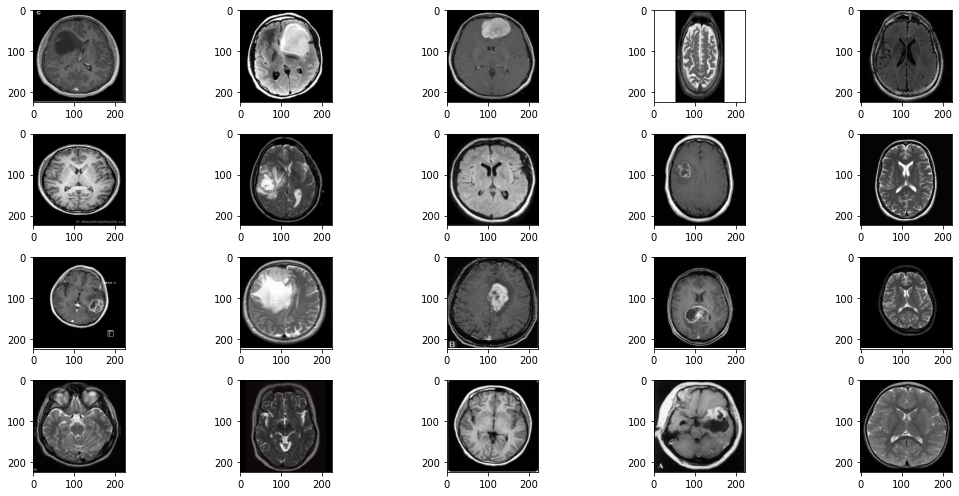

In [4]:
# show random image
img_idx=np.random.choice(np.arange(0,len(x_train)),20)

plt.figure(figsize=(15,7))

for x in range(len(img_idx)):
  plt.subplot(4,5,x+1)
  plt.imshow(x_train[img_idx[x]])

plt.tight_layout()
plt.show()

In [5]:
# create model
tf.keras.backend.clear_session()
model=tf.keras.models.Sequential()
# x_train.shape = (149, 224, 224, 3)
model.add(Conv2D(input_shape=(x_train.shape[-3],x_train.shape[-2],x_train.shape[-1]),filters=8,kernel_size=(3,3),padding="same", activation="relu"))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))

model.add(Flatten())
model.add(Dropout(0.5))
model.add(Dense(units=128,activation="relu"))
model.add(Dropout(0.5))
model.add(Dense(units=128,activation="relu"))
model.add(Dropout(0.5))
model.add(Dense(units=y_train.shape[-1], activation="sigmoid"))

model.compile(optimizer=tf.optimizers.Adam(learning_rate=0.001), 
              loss=tf.losses.BinaryCrossentropy(),
              metrics=['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 224, 224, 8)       224       
                                                                 
 batch_normalization (BatchN  (None, 224, 224, 8)      32        
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 112, 112, 8)      0         
 )                                                               
                                                                 
 flatten (Flatten)           (None, 100352)            0         
                                                                 
 dropout (Dropout)           (None, 100352)            0         
                                                                 
 dense (Dense)               (None, 128)               1

In [6]:
# train the model

history=model.fit(x_train,y_train,batch_size=8,epochs=30,validation_data=(x_test,y_test))

Epoch 1/30
23/23 [==============================] - 3s 42ms/step - loss: 8.5510 - accuracy: 0.6348 - val_loss: 0.8532 - val_accuracy: 0.8000
Epoch 2/30
23/23 [==============================] - 1s 22ms/step - loss: 4.1720 - accuracy: 0.6461 - val_loss: 0.7816 - val_accuracy: 0.8000
Epoch 3/30
23/23 [==============================] - 0s 21ms/step - loss: 4.2027 - accuracy: 0.6067 - val_loss: 0.5703 - val_accuracy: 0.8000
Epoch 4/30
23/23 [==============================] - 1s 23ms/step - loss: 0.9636 - accuracy: 0.7247 - val_loss: 0.5988 - val_accuracy: 0.4889
Epoch 5/30
23/23 [==============================] - 0s 21ms/step - loss: 0.9953 - accuracy: 0.7079 - val_loss: 0.4671 - val_accuracy: 0.8000
Epoch 6/30
23/23 [==============================] - 0s 21ms/step - loss: 0.8288 - accuracy: 0.7360 - val_loss: 0.5724 - val_accuracy: 0.7111
Epoch 7/30
23/23 [==============================] - 0s 21ms/step - loss: 0.7002 - accuracy: 0.7416 - val_loss: 0.5249 - val_accuracy: 0.7333
Epoch 8/30
23

In [8]:
# evaluate the model

train_result=model.evaluate(x_train,y_train,verbose=0)
test_result=model.evaluate(x_test,y_test,verbose=0)

print("<=======Result=======>")
print("Trian Loss     : ",round(train_result[0],ndigits=3))
print("Trian Accuracy :%",round(train_result[1]*100,ndigits=3))
print()
print("Test Loss      : ",round(test_result[0],ndigits=3))
print("Test Accuracy  :%",round(test_result[1]*100,ndigits=3))

<=======Result=======>
Trian Loss     :  0.094
Trian Accuracy :% 94.944

Test Loss      :  0.476
Test Accuracy  :% 88.889


In [9]:
# save the model
model.save("Brain_Tumor_Detection.h5")